# Feature Engineering

## Objectives

This notebook implements **feature engineering** actions recommended by the exploratory analysis in Notebook 04. The goal is to transform raw and enriched datasets into modeling-ready features that address rating inflation, correct skewed distributions, and aggregate user-level signals for clustering and personalization.

Key priorities:

* Bayesian/weighted ratings to correct sample-size bias
* Log transformations for skewed count features
* User profile aggregation for segmentation and clustering
* Save feature-engineered datasets for modeling

---

## Inputs

* `internal_catalog_analysis.csv` — feature-engineered internal catalog
* `supply_catalog_analysis.csv` — feature-engineered supply catalog
* `ratings_clean_v1.csv` — cleaned user–book interactions
* `user_activity.csv`, `user_diversity.csv`, `user_genre_prefs.csv` — user-level analysis datasets
* `model_dataset_warm_start.csv` — unified metadata + external signals (for validation)

---

## Tasks in This Notebook

1. **Load Data**
    Import feature-engineered catalogs and user interaction datasets.

2. **Implement Bayesian/Weighted Ratings**
   Apply Bayesian average formula to correct rating inflation in low-volume books, authors, genres, and publishers.

3. **Apply Log Transformations**
   Transform skewed count features (ratings, author/publisher book counts) for regression compatibility.

4. **Aggregate User Profile Features**
   Merge rating, diversity, and preference metrics into user-level features for clustering and segmentation.

5. **Save Feature-Engineered Datasets**
   Export modeling-ready datasets for downstream tasks.

---

## Outputs

* Feature-engineered catalogs with weighted ratings and log-transformed features
* Aggregated user profile dataset for clustering and personalization
* Modeling-ready datasets saved to `outputs/datasets/modeling/`
* Documentation of feature engineering logic and business rationale

>**Note:**
>This notebook focuses on **feature engineering only**.
>Model training and evaluation are completed in the following notebooks.

# Set up

## Navigate to the Parent Directory

Before combining and saving datasets, it’s often helpful to move to a parent directory so that file operations (like loading or saving data) are easier and more organized. 

Before using the Python’s built-in os module to move one level up from the current working directory, it is advisable to inspect the current directory.

In [1]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f'Current directory: {current_dir}')

Current directory: c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics\notebooks


To change to parent directory (root folder), run the code below. If you are already in the root folder, you can skip this step.

In [2]:
# Change the working directory to its parent
os.chdir(os.path.dirname(current_dir))
print('Changed directory to parent.')

# Get the new current working directory (the parent directory)
current_dir = os.getcwd()
print(f'New current directory: {current_dir}')

Changed directory to parent.
New current directory: c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics


## Load Datasets

In this step, we load the previously cleaned datasets for analysis.

In [3]:
import pandas as pd

# catalogs
internal_catalog_fe = pd.read_csv('outputs/datasets/analysis/internal_catalog_analysis.csv')

# ratings and user-level analysis
ratings = pd.read_csv('outputs/datasets/cleaned/ratings_clean.csv')
user_activity = pd.read_csv('outputs/datasets/analysis/user_activity.csv')
user_diversity = pd.read_csv('outputs/datasets/analysis/user_diversity.csv')
book_genre_mapping = pd.read_csv('outputs/datasets/analysis/internal_book_genre_mapping.csv')

# unified metadata for validation
warm_start = pd.read_csv('outputs/datasets/cleaned/model_dataset_warm_start.csv')

print(f"Internal catalog shape: {internal_catalog_fe.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"User activity shape: {user_activity.shape}")
print(f"User diversity shape: {user_diversity.shape}")
print(f"Warm start dataset shape: {warm_start.shape}")
print(f"Internal Catalog book-genre mapping: {book_genre_mapping.shape}")

Internal catalog shape: (9761, 47)
Ratings shape: (5976479, 3)
User activity shape: (53424, 2)
User diversity shape: (53423, 7)
Warm start dataset shape: (9761, 38)
Internal Catalog book-genre mapping: (76001, 3)


# Log Transformations

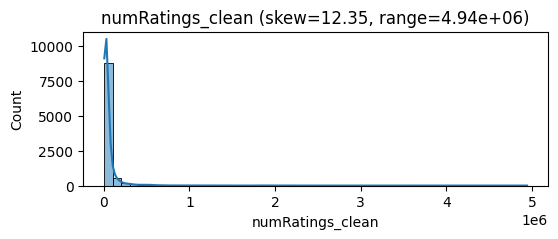

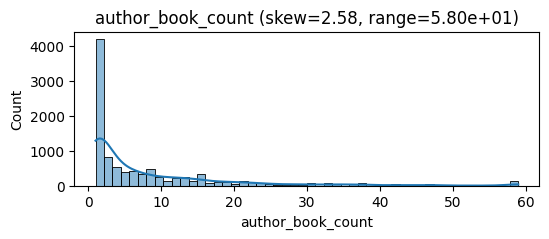

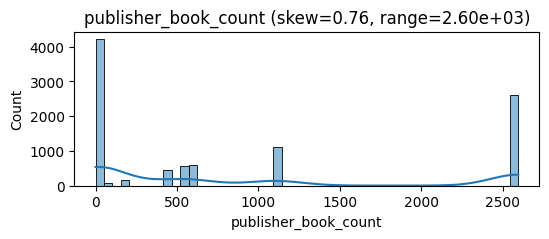

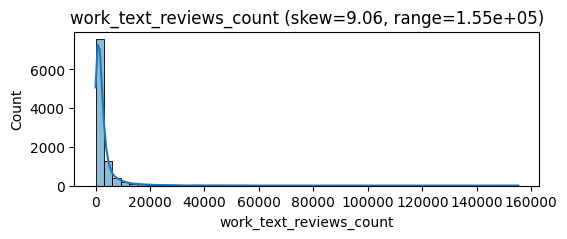

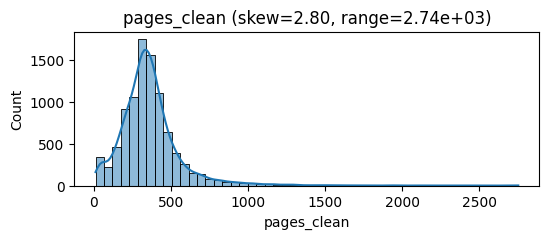

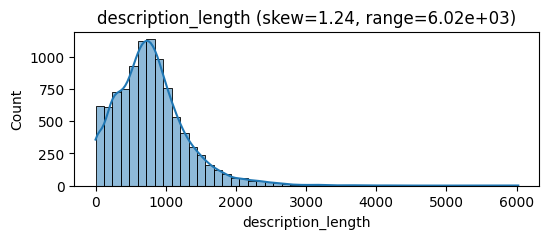

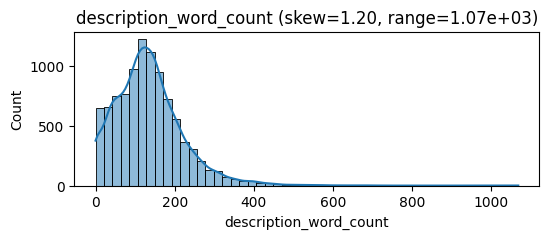

,feature,min,max,range,skew,pct_zeros,pct_ones,mean,std
0,numRatings_clean,6323.0,4942365.0,4936042.0,12.351883,0.000000,0.000000,60402.797049,169229.055839
3,work_text_reviews_count,3.0,155254.0,155251.0,9.057901,0.000000,0.000000,2951.144760,6184.590107
4,pages_clean,10.0,2752.0,2742.0,2.795178,0.000000,0.000000,361.117873,201.854152
1,author_book_count,1.0,59.0,58.0,2.576448,0.000000,0.330192,7.649319,10.272070
5,description_length,0.0,6025.0,6025.0,1.237318,0.042209,0.000102,784.641738,502.650949
6,description_word_count,0.0,1068.0,1068.0,1.195267,0.042209,0.000512,134.231124,85.357213
2,publisher_book_count,0.0,2596.0,2596.0,0.760935,0.035345,0.072226,911.857392,1071.141329


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

def check_skew_and_range(df, features, plot=True):
    results = []
    for col in features:
        if col not in df.columns:
            continue
        vals = df[col].dropna()
        if not np.issubdtype(vals.dtype, np.number):
            continue
        rng = vals.max() - vals.min()
        skw = skew(vals)
        pct_zeros = (vals == 0).mean()
        pct_ones = (vals == 1).mean()
        results.append({
            'feature': col,
            'min': vals.min(),
            'max': vals.max(),
            'range': rng,
            'skew': skw,
            'pct_zeros': pct_zeros,
            'pct_ones': pct_ones,
            'mean': vals.mean(),
            'std': vals.std(),
        })
        if plot:
            plt.figure(figsize=(6,2))
            sns.histplot(vals, bins=50, kde=True)
            plt.title(f"{col} (skew={skw:.2f}, range={rng:.2e})")
            plt.show()
    return pd.DataFrame(results).sort_values('skew', ascending=False)

# internal catalog features to check
features_to_check = [
    'numRatings_clean', 'author_book_count', 'publisher_book_count',
    'work_text_reviews_count', 'pages_clean', 'description_length', 'description_word_count',
]
check_skew_and_range(internal_catalog_fe, features_to_check)

| Feature                   | Range   | Skew    | Power Law                  | Distribution Shape         | Log Transform? |
|---------------------------|---------|---------|----------------------------|---------------------------|:--------------:|
| numRatings_clean          | High    | High    | Yes, extreme long tail     | Extreme right skew, power law |      Yes       |
| work_text_reviews_count   | High    | High    | Yes, long tail             | Extreme right skew        |      Yes       |
| pages_clean               | High    | High    | Weak, some long tail       | Right skew                |      Yes       |
| author_book_count         | Medium  | High    | Yes, long tail             | Right skew                |      Yes       |
| description_length        | High    | Low     | No, mild tail              | Mild right skew           |   Optional     |
| description_word_count    | Medium  | Low     | No, mild tail              | Mild right skew           |   Optional     |
| publisher_book_count      | High    | Low     | Bimodal, some long tail    | Bimodal, moderate skew    |   Consider     |


**Summary:**  
- **Apply log transform** to features with high skew (>2) and/or very large ranges:  
  `numRatings_clean` (already done), `work_text_reviews_count`(already done), `pages_clean`, `author_book_count`
- **Optional** for features with mild skew but large range:  
  `description_length`, `description_word_count`
- **Consider** for `publisher_book_count` if model performance improves.



> note: A power law is a type of statistical distribution where a small number of items have very large values, while most items have small values. This results in a long tail on the right side of the distribution curve.

In [5]:
# apply log1 to selected features
internal_catalog_fe['author_book_count_log'] = np.log1p(internal_catalog_fe['author_book_count'])
internal_catalog_fe['pages_log'] = np.log1p(internal_catalog_fe['pages_clean'])
internal_catalog_fe['description_length_log'] = np.log1p(internal_catalog_fe['description_length'])
internal_catalog_fe['description_word_count_log'] = np.log1p(internal_catalog_fe['description_word_count'])
internal_catalog_fe['publisher_book_count_log'] = np.log1p(internal_catalog_fe['publisher_book_count'])

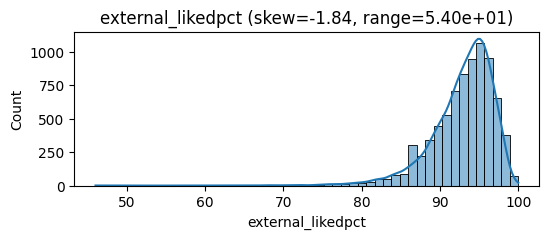

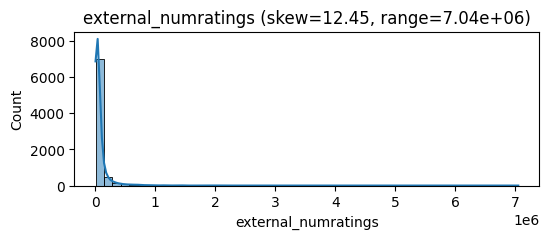

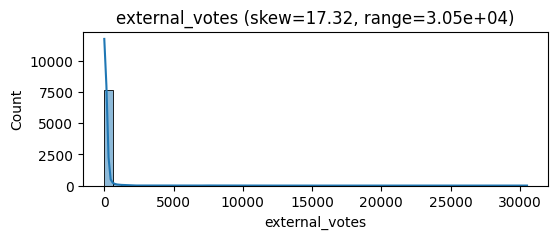

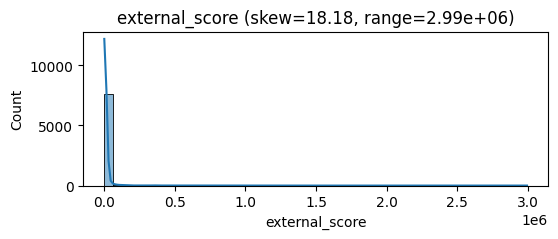

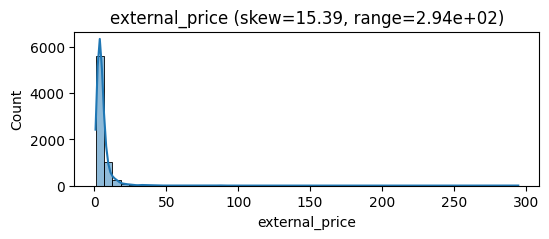

,feature,min,max,range,skew,pct_zeros,pct_ones,mean,std
3,external_score,1.00,2993816.00,2993815.00,18.178115,0.0,0.000128,10938.357161,85681.676751
2,external_votes,1.00,30516.00,30515.00,17.315379,0.0,0.129563,124.057570,897.884409
4,external_price,0.84,294.72,293.88,15.389222,0.0,0.000428,5.746640,8.853542
1,external_numratings,7136.00,7048471.00,7041335.00,12.451248,0.0,0.000000,87511.021573,240015.160514
0,external_likedpct,46.00,100.00,54.00,-1.843614,0.0,0.000000,92.847843,4.032908


In [6]:
# external features to check
external_features_to_check = [
    'external_likedpct',
    'external_numratings',
    'external_votes',
    'external_score',
    'external_price'
]
check_skew_and_range(warm_start, external_features_to_check)

| Feature             | Range   | Skew    | Power Law                  | Distribution Shape         | Log Transform? |
|---------------------|---------|---------|----------------------------|---------------------------|:--------------:|
| external_score      | High    | High    | Yes, extreme long tail     | Extreme right skew        |      Yes       |
| external_votes      | High    | High    | Yes, long tail             | Extreme right skew        |      Yes       |
| external_price      | High    | High    | Yes, long tail             | Extreme right skew        |      Yes       |
| external_numratings | High    | High    | Yes, extreme long tail     | Extreme right skew        |      Yes       |
| external_likedpct   | Low     | Low     | No, concentrated           | Mild left skew            |      No        |

**Summary:**  
- **Apply log transform** to all external features with high skew and/or very large ranges and power-law tails:  
  `external_score`, `external_votes`, `external_price`, `external_numratings`
- **No log transform** needed for `external_likedpct` due to low skew and narrow range.

In [7]:
# Log-transform external features with high skew and range
warm_start['external_score_log'] = np.log1p(warm_start['external_score'])
warm_start['external_votes_log'] = np.log1p(warm_start['external_votes'])
warm_start['external_price_log'] = np.log1p(warm_start['external_price'])
warm_start['external_numratings_log'] = np.log1p(warm_start['external_numratings'])
# No log transform for external_likedpct

# Popularity Score

In [8]:
# Standardize features (z-score)
for col in ['work_text_reviews_log', 'numRatings_log', 'rating_clean']:
    internal_catalog_fe[f'{col}_z'] = (internal_catalog_fe[col] - internal_catalog_fe[col].mean()) / internal_catalog_fe[col].std()

# Create popularity score (equal weights)
internal_catalog_fe['popularity_score'] = (
    internal_catalog_fe['work_text_reviews_log_z'] +
    internal_catalog_fe['numRatings_log_z'] +
    internal_catalog_fe['rating_clean_z']
)

# Preview top popular books
internal_catalog_fe[['title_clean', 'popularity_score', 'work_text_reviews_log', 'numRatings_log', 'rating_clean']].sort_values('popularity_score', ascending=False).head(10)

,title_clean,popularity_score,work_text_reviews_log,numRatings_log,rating_clean
0,the hunger games,10.912187,11.952824,15.413355,4.34
1,harry potter and the sorcerer's stone,10.660146,11.236750,15.384140,4.44
24,harry potter and the deathly hallows,9.966894,10.857902,14.429288,4.61
5,the fault in our stars,9.760013,11.854669,14.723208,4.26
30,the help,9.531917,11.267089,14.287728,4.45
3,to kill a mockingbird,9.476308,11.192541,15.021750,4.25
17,harry potter and the prisoner of azkaban,9.407397,10.494048,14.493227,4.53
16,catching fire,9.279590,11.391198,14.502680,4.30
11,divergent,9.274347,11.523113,14.611582,4.24
23,harry potter and the goblet of fire,9.221641,10.344481,14.440723,4.53


In [9]:
import numpy as np

# Standardize features (z-score)
for col in ['external_rating', 'external_numratings_log', 'external_votes_log', 'external_score_log', 'external_likedpct']:
    warm_start[f'{col}_z'] = (warm_start[col] - warm_start[col].mean()) / warm_start[col].std()

# Create external popularity score (equal weights)
warm_start['external_popularity_score'] = (
    warm_start['external_rating_z'] +
    warm_start['external_numratings_log_z'] +
    warm_start['external_votes_log_z'] +
    warm_start['external_score_log_z'] +
    warm_start['external_likedpct_z']
)

# Preview top popular items
warm_start[['title_final', 'external_popularity_score', 'external_rating', 'external_numratings', 'external_votes', 'external_score', 'external_likedpct']].sort_values('external_popularity_score', ascending=False).head(10)

,title_final,external_popularity_score,external_rating,external_numratings,external_votes,external_score,external_likedpct
20,harry potter and the order of the phoenix,17.053656,4.50,2507623.0,26923.0,2632233.0,98.0
0,the hunger games,16.982404,4.33,6376780.0,30516.0,2993816.0,96.0
1,harry potter and the sorcerer's stone,15.953274,4.47,7048471.0,7348.0,691430.0,96.0
3,to kill a mockingbird,15.835189,4.28,4501075.0,23328.0,2269402.0,95.0
24,harry potter and the deathly hallows,15.318452,4.62,2811637.0,3835.0,351347.0,98.0
30,the help,15.256965,4.47,2164011.0,7693.0,718236.0,98.0
17,harry potter and the prisoner of azkaban,14.955550,4.57,2806471.0,2770.0,247736.0,99.0
9,pride and prejudice,14.917979,4.26,2998241.0,20452.0,1983116.0,94.0
46,the book thief,14.917939,4.37,1834276.0,14168.0,1372809.0,96.0
23,harry potter and the goblet of fire,14.459223,4.56,2594622.0,2049.0,178933.0,99.0


# User Profile Aggregation

In [10]:
print(user_activity.columns)

Index(['user_id', 'rating_count'], dtype='object')


In [11]:
# join ratings with internal catalog features on book_id
user_book = ratings.merge(
    internal_catalog_fe[['book_id', 'publication_year_clean', 'pages_clean', 'has_award_encoded', 'is_major_publisher_encoded', 'genre_count', 'popularity_score']],
    on='book_id', how='left'
)

# aggregate to user level
user_profile = user_book.groupby('user_id').agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    pub_year_mean=('publication_year_clean', 'mean'),
    pages_mean=('pages_clean', 'mean'),
    award_pref=('has_award_encoded', 'mean'),
    major_pub_pref=('is_major_publisher_encoded', 'mean'),
    genre_count_mean=('genre_count', 'mean'),
    popularity_mean=('popularity_score', 'mean')
).reset_index()

# merge with user activity and diversity
user_profile = user_profile.merge(
    user_diversity, on='user_id', how='left'
)
user_profile = user_profile.merge(
    user_activity, on='user_id', how='left'
)

print(user_profile.head())

   user_id  rating_count_x  rating_mean  rating_std  pub_year_mean  \
0        1             117     3.589744    0.957312    1977.299145   
1        2              65     4.415385    0.845804    1980.738462   
2        3              91     1.736264    0.892377    1967.344444   
3        4             134     3.768657    0.995586    1966.537879   
4        5             100     4.040000    0.737454    2000.760417   

   pages_mean  award_pref  major_pub_pref  genre_count_mean  popularity_mean  \
0  424.396552    0.632479        0.769231          8.324786         4.151893   
1  355.578125    0.446154        0.615385          7.876923         3.331756   
2  327.384615    0.505495        0.725275          9.197802         1.863634   
3  385.610687    0.530303        0.666667          9.083333         4.256617   
4  375.617978    0.552083        0.645833          6.947917         1.469687   

   num_genres  genre_diversity  genre_concentration  top_genre_share  \
0       142.0         4.02

# Save Datasets

In [16]:
from pathlib import Path
# create directory
modeling_dir = Path('outputs/datasets/modeling')
modeling_dir.mkdir(parents=True, exist_ok=True)

user_profile.to_csv(modeling_dir / 'user_profile_features.csv', index=False)